#### This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

In [1]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the single-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [2]:
file = '/mnt/sdc/FastMRI/singlecoil_train/file1002569.h5'
hf = h5py.File(file)

In [3]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {'norm': 0.327495382705101, 'max': 0.0008807593449222425, 'patient_id': 'b342cf1f5bb020289b8afdae32ce74208009fe13c291d8c84fedcfb45602e0e8', 'acquisition': 'CORPD_FBK'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [4]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(36, 640, 356)


In [5]:
slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume

Let's see what the absolute value of k-space looks like:

In [6]:
def show_slices(data, cmap=None):
    fig = plt.figure()
    plt.imshow(data, cmap=cmap)

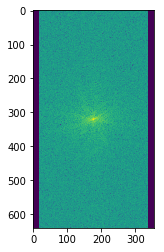

In [7]:
show_slices(np.log(np.abs(slice_kspace) + 1e-9))  # This shows slices 0, 5 and 10

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [8]:
from data import transforms as T

In [9]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = T.ifft2(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = T.complex_abs(slice_image)   # Compute absolute value to get a real image

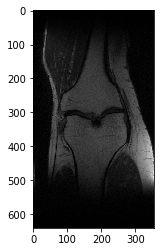

In [10]:
show_slices(slice_image_abs, cmap='gray')

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [11]:
from common.subsample import MaskFunc
mask_func = MaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [12]:
masked_kspace, mask = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

Let's see what the subsampled image looks like:

In [13]:
sampled_image = T.ifft2(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = T.complex_abs(sampled_image)   # Compute absolute value to get a real image

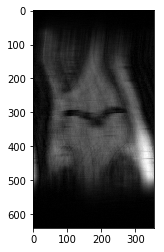

In [14]:
plt.imshow(np.abs(sampled_image_abs.numpy()), cmap='gray')